In [396]:
import pandas as pd 
import numpy as np
import seaborn as sns
import datetime

bill_1403 = pd.read_excel("حواله 1403.xlsx", usecols=["شرح آیتم", "Min-Max", "بخش مصرف کننده", "درخواست کننده", "مقدار اوليه درخواستي",
                                                     "میانگین مصرف کل", "مصرف جاری", "میانگین مصرف بخش", "حواله در جریان",
                                                     "حواله بين راهي", "حواله خريد", "PR_Qty", "PO_Qty", "RECEIPT_Qty", "مقدار تاييد شده", "مقدار تحویل داده شده",
                                                     "COMMENTED", "ACTION", "کد پلنر", "تاریخ", "نوع حواله", "موجودی انبار فرعی", "ON_HAND"])

print("تعداد سطر و ستون",bill_1403.shape)
#print("آمار توصیفی ستون های کلیدی\n", bill_1403[key_columns].describe())
print("تعداد عملیات انجام شده توسط پلنر:")
print(bill_1403["ACTION"].value_counts())
print("داده های ناقص/گم شده از هر ستون:")
#for a in key_columns:
#    if bill_1403[a].isnull().sum() > 0:
#        bill_1403[a] = bill_1403[a].fillna(0)

print(bill_1403.isnull().sum())
print("لیست ستون ها", bill_1403.columns.tolist())
# چاپ نام ستون‌ها با escape تا کاراکترهای پنهان مشخص بشن
#print([ (c if not isinstance(c, str) else repr(c)) for c in bill_1403.columns.tolist() ])

تعداد سطر و ستون (52026, 23)
تعداد عملیات انجام شده توسط پلنر:
ACTION
APPROVE    42882
REJECT      9144
Name: count, dtype: int64
داده های ناقص/گم شده از هر ستون:
شرح آیتم                    0
Min-Max                     0
بخش مصرف کننده             16
درخواست کننده              43
مقدار اوليه درخواستي        0
میانگین مصرف کل             7
مصرف جاری               23415
میانگین مصرف بخش            0
ON_HAND                     0
حواله در جریان              0
حواله بين راهي              0
حواله خريد                  0
PR_Qty                      0
PO_Qty                      0
RECEIPT_Qty                 0
مقدار تاييد شده             0
مقدار تحویل داده شده     9814
COMMENTED               46117
ACTION                      0
کد پلنر                     0
تاریخ                       0
نوع حواله                   0
موجودی انبار فرعی           0
dtype: int64
لیست ستون ها ['شرح آیتم', 'Min-Max', 'بخش مصرف کننده', 'درخواست کننده', 'مقدار اوليه درخواستي', 'میانگین مصرف کل', 'مصرف جاری', 'میانگ

In [398]:
bill_1403["bill_type_backup"] = bill_1403.get("نوع حواله")
bill_1403["Min-Max_backup"] = bill_1403.get("Min-Max")
bill_1403["نوع حواله"] = bill_1403["نوع حواله"].replace(["nan", "NaN", "None", "NULL"], np.nan)
bill_1403["Min-Max"] = bill_1403["Min-Max"].replace(["nan", "NaN", "None", "NULL"], np.nan)

#print("✅ تعداد ستون‌های نهایی:", len(bill_1403.columns))
#print("✅ نمونه‌ای از نام ستون‌ها:", bill_1403.columns[:10].tolist())

bill_1403["Requested_Qty"] = bill_1403["مقدار اوليه درخواستي"].copy() # مقدار/تعداد درخواستی
bill_1403["Allocated_Qty"] = bill_1403["مقدار تاييد شده"] # مقدار/تعداد تخصیص داده شده
bill_1403["planner_code"] = bill_1403["کد پلنر"]
bill_1403["stock_level"] = bill_1403["ON_HAND"]
bill_1403["Decision"] = bill_1403["ACTION"]  # APPROVE/REJECT و غیره
bill_1403["Delivered_Qty"] = bill_1403["مقدار تحویل داده شده"]
bill_1403["seg_prd"] = bill_1403["مصرف جاری"]
bill_1403["seg_avg"] = bill_1403["میانگین مصرف بخش"]
bill_1403["total_avg"] = bill_1403["میانگین مصرف کل"]
bill_1403["inflow"] = bill_1403["حواله در جریان"]
bill_1403["intransit"] = bill_1403["حواله بين راهي"]
bill_1403["bill_type"] = bill_1403["نوع حواله"]

bill_1403["allocation_ratio"] = bill_1403["Allocated_Qty"]/(bill_1403["Requested_Qty"].replace(0, np.nan))

#order_data["حواله در جریان"].fillna(0, inplace=True) #filling empty cells with 0
#order_data.count()

bill_1403["date_billCreated"] = pd.to_datetime(bill_1403["تاریخ"], errors='coerce')
#bill_1403["Date_plannerReceived"] = pd.to_datetime(bill_1403["تاریخ دريافت حواله توسط پلنر"], errors='coerce')

# چک تفاوت تخصیص و تحویل (برای دیدن تغییر توسط انبار)
bill_1403["delivery_difference"] = bill_1403["Allocated_Qty"] - bill_1403["Delivered_Qty"] #منفی یعنی انبار کمتر داده 

# چک تفاوت درخواستی اولیه با مقدار تخصیص داده شده
bill_1403["allocation_difference"] = bill_1403["Requested_Qty"] - bill_1403["Allocated_Qty"] 

# حذف ردیف‌های ناقص (برای ستون‌های کلیدی)
#bill_1403= bill_1403.dropna(subset = ["Requested_Qty", "Allocated_Qty", "Stock_level"])
# --- ساخت فیچرهای ترکیبی ---

bill_1403['stock_coverage'] = bill_1403['stock_level'] / bill_1403['Requested_Qty'].replace(0, 1) #درصد پوشش موجودی 
bill_1403['stock_to_demand'] = bill_1403['stock_level'] / (bill_1403['total_avg'].replace(0, np.nan)) # موجودی به مصرف کل
bill_1403['stock_to_seg_prd'] = bill_1403['stock_level'] / (bill_1403['seg_prd'].replace(0, np.nan)) # موجودی به مصرف جاری بخش
bill_1403['stock_to_seg_avg'] = bill_1403['stock_level'] / (bill_1403['seg_avg'].replace(0, np.nan)) # موجودی به میانگین مصرف بخش

bill_1403['period_to_total_avg'] = bill_1403['seg_prd'] / bill_1403['total_avg'].replace(0, 1) #چقدر مصرف فعلی غیرعادیه؟

bill_1403['inflow_ratio'] = bill_1403['inflow'] / bill_1403['Requested_Qty'].replace(0, 1) # حواله در جریان به اولیه درخواستی
bill_1403['intransit_ratio'] = bill_1403['intransit'] / bill_1403['Requested_Qty'].replace(0, 1) # حواله بین راهی به اولیه درخواستی

bill_1403['total_intransit_ratio'] = bill_1403['intransit'] / ((bill_1403['inflow'] + bill_1403['intransit']).replace(0, 1)
)
bill_1403['total_inflow_ratio'] = bill_1403['inflow'] / ((bill_1403['inflow'] + bill_1403['intransit']).replace(0, 1)
)


bill_1403['intransit_to_total_avg'] = bill_1403['intransit'] / (bill_1403['total_avg'].replace(0, np.nan)) # نسبت حواله های بین راهی به میانگین مصرف کل

bill_1403['segment_pressure'] = bill_1403['seg_avg'] / bill_1403['total_avg'].replace(0, 1)
bill_1403['demand_pressure'] = bill_1403['seg_prd'] / bill_1403['total_avg'].replace(0, 1)
bill_1403['stock_pressure'] = (bill_1403['Requested_Qty'] - bill_1403['stock_level']) / bill_1403['Requested_Qty'].replace(0, 1)
bill_1403['inventory_pressure'] = bill_1403['stock_level'] / (bill_1403['total_avg'] + bill_1403['intransit'] + bill_1403['inflow'].replace(0, 1))

# -------------------------
# مرحله ۳: تبدیل categorical به عددی
# -------------------------
bill_1403['نوع حواله'] = bill_1403['نوع حواله'].str.strip().str.replace('\u200c','')  # حذف فاصله و نیم‌فاصله
print(bill_1403['نوع حواله'].unique())
text_cols = ["Min-Max", "bill_type"]
bill_1403 = pd.get_dummies(bill_1403, columns=text_cols, drop_first=False)
# جایگزینی NaN و Inf با 0
bill_1403 = bill_1403.replace([np.inf, -np.inf], np.nan)
bill_1403 = bill_1403.fillna(0)
# چک کردن نمونه داده‌ها
bill_1403.to_csv("cleaned_bill_1403.csv", 
                 index=False, encoding="utf-8")
print("دیتای تمیز ذخیره شد! تعداد ردیف‌های باقی‌مانده:", bill_1403.shape[0])

# نمونه ۵ ردیف تمیز شده
print("\nنمونه ۵ ردیف تمیز شده:")
print(bill_1403.head(5))
print("لیست ستون ها", bill_1403.columns.tolist())
#print(order_data.dtypes)
#print(order_data.describe())
#print(order_data["میانگین مصرف کل"].mean())
#print(order_data.groupby(["شرح آیتم"])["Requested_Qty"].sum())

C:\Users\user\AppData\Local\Temp\ipykernel_7140\488929489.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bill_1403["date_billCreated"] = pd.to_datetime(bill_1403["تاریخ"], errors='coerce')


['جهت صدور درخواست خريد' 'جهت تنخواه' 'جهت دريافت كالا از موجودي انبار'
 'جهت خريد اقلام ساختني']


C:\Users\user\AppData\Local\Temp\ipykernel_7140\488929489.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bill_1403 = bill_1403.fillna(0)


دیتای تمیز ذخیره شد! تعداد ردیف‌های باقی‌مانده: 52026

نمونه ۵ ردیف تمیز شده:
                                            شرح آیتم  \
0  cylinder size:320*600*220mm ست كامل آب بند سيل...   
1                                    چراغ سقفي روكار   
2                               كلريد كلسيم M:102379   
3         T=0.13m.m W=18m.m  L=10yard  نوار چسب مشكي   
4         T=0.13m.m W=18m.m  L=10yard  نوار چسب قرمز   

                                      بخش مصرف کننده            درخواست کننده  \
0                   مديريت فولادسازي  تجهيزات مكانيك       محمدعلي  عباسعليان   
1    مديريت بخش كوره بلند كوره بلند عمومي و پشتيباني  اصغر  جلالي ورنامخواستي   
2  مديريت آزمايشگاه ها و مركز تحقيقات  آزمايشگاه ...            اصغر  شاهپوري   
3               مديريت توليدوتوزيع برق   شبكه وپستها              حسين  كريمي   
4               مديريت توليدوتوزيع برق   شبكه وپستها              حسين  كريمي   

   مقدار اوليه درخواستي  میانگین مصرف کل  مصرف جاری  میانگین مصرف بخش  \
0                   8.0  

X.nunique: 
 stock_level                5466
seg_prd                     589
total_avg                  1891
seg_avg                    1876
stock_to_seg_avg          18018
intransit_ratio            2506
stock_to_demand           16232
stock_to_seg_prd           9034
inflow_ratio               1210
stock_coverage            10488
total_intransit_ratio      1841
total_inflow_ratio         1841
intransit_to_total_avg     7521
segment_pressure           8327
stock_pressure            10495
inventory_pressure        22837
demand_pressure            2158
Min-Max_YES                   2
Min-Max_NO                    2
bill_type_tankhah             2
bill_type_wr                  2
bill_type_pr                  2
dtype: int64
تعداد بر هر کلاس: 
 y
1    42882
0     9144
Name: count, dtype: int64
   stock_level  seg_prd  total_avg  seg_avg  stock_to_seg_avg  \
0          0.0      0.0       2.67     2.67          0.000000   
1          0.0      0.0      10.00     0.00          0.000000   
2    

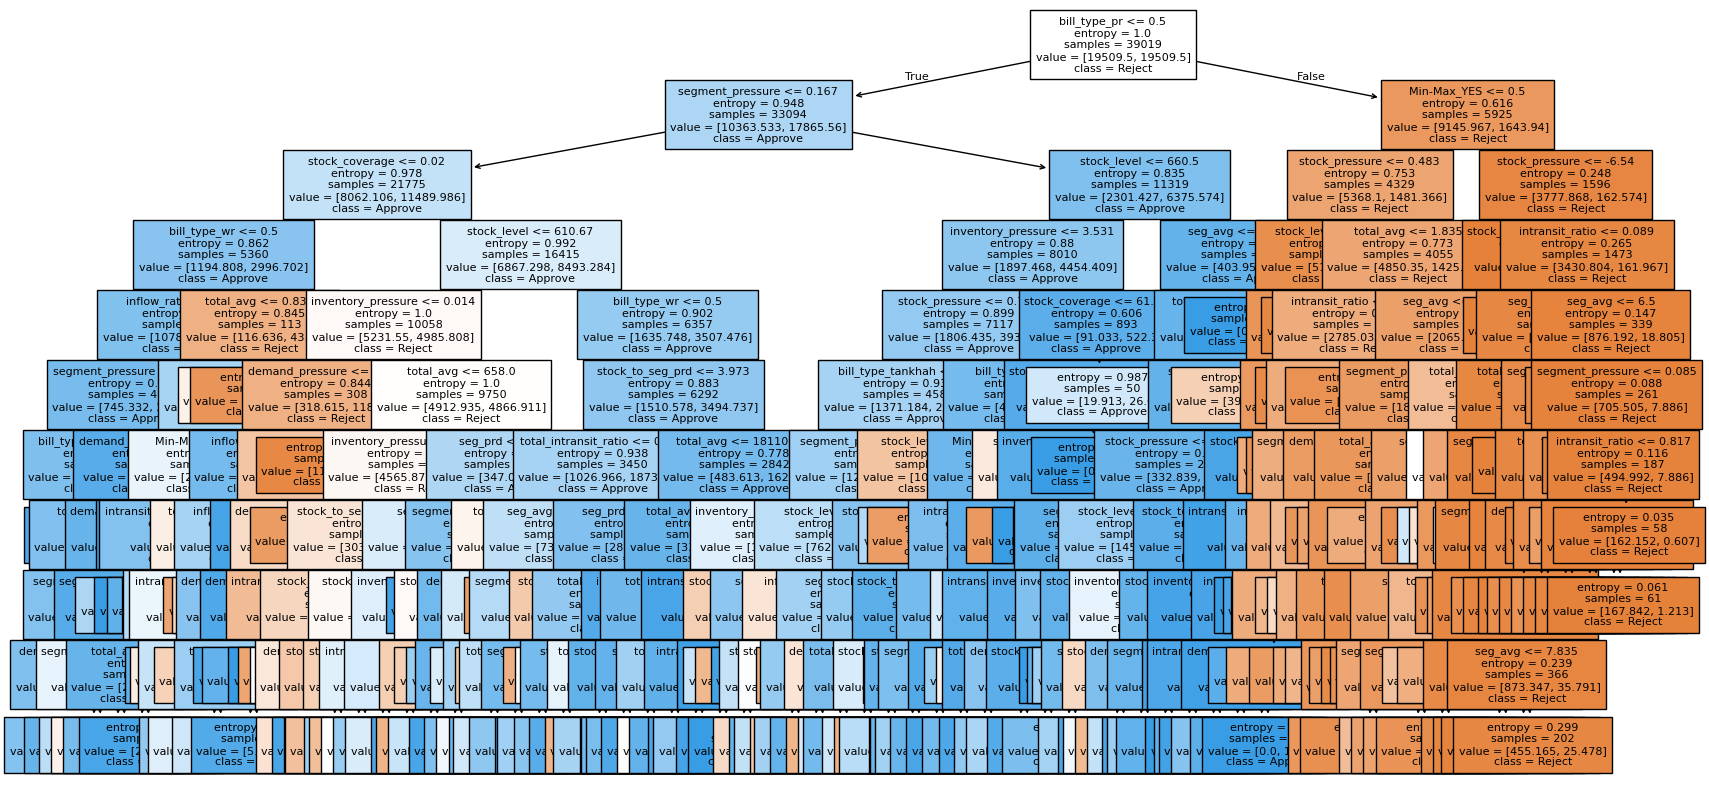

In [410]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree


#print(df.columns.tolist())
target_col = ["Decision"]
feature_cols = ['stock_level','میانگین مصرف کل','مصرف جاری','میانگین مصرف بخش','حواله در جریان','حواله بين راهي'
                ,'Min-Max','نوع حواله','نسبت تخصیص به مقدار اولیه درخواستی'
                ,'درصد پوشش موجودی','درصد مصرف جاری به میانگین مصرف کل','نسبت حواله در جریان به مقدار اولیه درخواستی'
                ,'نسبت حواله های بین راهی به کل حواله ها','شدت تقاضا بخش','شاخص فشار موجودی']

#print("فیچرهای کلیدی:", feature_cols)
# ---------------------------
# 1) پاکسازی مختصر و آماده‌سازی
# ---------------------------
bill_1403 = bill_1403.rename(columns={
    "bill_type_جهت دريافت كالا از موجودي انبار":"bill_type_wr",
    "bill_type_جهت صدور درخواست خريد": "bill_type_pr",
    "bill_type_جهت تنخواه": "bill_type_tankhah"
}  
)
# فیلتر برای نوع حواله "دریافت از موجودی انبار warehouse remittance"
#wr = bill_1403[bill_1403["bill_type"].str.contains('bill_type_wr', na=False)].copy()
key_cols = ['stock_level', 'seg_prd', 'total_avg', 'seg_avg', 'stock_to_seg_avg', 'intransit_ratio', 'stock_to_demand',
            'stock_to_seg_prd', 'inflow_ratio', 'stock_coverage', 'total_intransit_ratio', 'total_inflow_ratio',
           'intransit_to_total_avg', 'segment_pressure', 'stock_pressure', 'inventory_pressure','demand_pressure','Min-Max_YES',
            'Min-Max_NO',"bill_type_tankhah", 'bill_type_wr', 'bill_type_pr']
#key_cols = [col for col in key_cols if col not in ['bill_type_pr', 'bill_type_tankhah']]
if "bill_type_جهت خريد اقلام ساختني" in bill_1403.columns:
    bill_1403 = bill_1403.drop(columns=["bill_type_جهت خريد اقلام ساختني"])


X = bill_1403[key_cols]
#selected_cols = [col for col in X.columns if not col.startswith("bill_type_") or col =='bill_type_wr']
#X = X[selected_cols]
#X = X.drop(['bill_type_pr'], axis=1)


bill_1403['y'] = np.where(bill_1403[target_col] == "APPROVE", 1, 0)
y = bill_1403['y']
#print(X.describe())
print("X.nunique: \n", X.nunique())
print("تعداد بر هر کلاس: \n", y.value_counts(dropna=False))


for c in key_cols:
   if X[c].isnull().sum() > 0:
       X[c] = X[c].fillna(0)

print(X.head(5))
print(X.shape)
#wr.to_csv("cleaned_wr.csv", index=False, encoding="utf-8")

# اگر همه مقادیر یک ستون ثابت بود، درخت نمی‌تونه باهاش کاری کنه:
for b in key_cols:
    if X[b].nunique() <= 1:
        print(f"تذکر: ستون {c} مقدار یکتای کم/ثابتی دارد -> ممکن است بی‌اثر باشد.")



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
clf = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=50, class_weight="balanced", criterion= 'entropy')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# --- 8) اهمیت ویژگی‌ها ---
importances = pd.Series(clf.feature_importances_, index=key_cols).sort_values(ascending=False)
print("Feature importances:\n", importances)

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=list(X.columns), class_names=['Reject','Approve'], filled=True, fontsize=8)
plt.show()

In [376]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [10, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
best_clf = grid.best_estimator_

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 50}


In [412]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=200,       # تعداد درخت‌ها
    max_depth=10,           # حداکثر عمق هر درخت
    min_samples_leaf=50,    # حداقل نمونه در هر برگ
    class_weight='balanced',
    random_state=42,
    n_jobs=-1               # استفاده از تمام هسته‌ها
)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [416]:
y_pred = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
# گزارش طبقه‌بندی
cr = classification_report(y_test, y_pred)
print("Classification report:\n", cr)

# اهمیت ویژگی‌ها
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature importances:\n", importances)

Confusion Matrix:
 [[1469  817]
 [1714 9007]]
Classification report:
               precision    recall  f1-score   support

           0       0.46      0.64      0.54      2286
           1       0.92      0.84      0.88     10721

    accuracy                           0.81     13007
   macro avg       0.69      0.74      0.71     13007
weighted avg       0.84      0.81      0.82     13007

Feature importances:
                    Feature  Importance
21            bill_type_pr    0.320013
19       bill_type_tankhah    0.107380
20            bill_type_wr    0.104066
0              stock_level    0.052201
14          stock_pressure    0.043036
9           stock_coverage    0.041024
13        segment_pressure    0.039507
15      inventory_pressure    0.036472
3                  seg_avg    0.033442
2                total_avg    0.033128
6          stock_to_demand    0.030628
1                  seg_prd    0.023410
4         stock_to_seg_avg    0.023214
7         stock_to_seg_prd    0.019

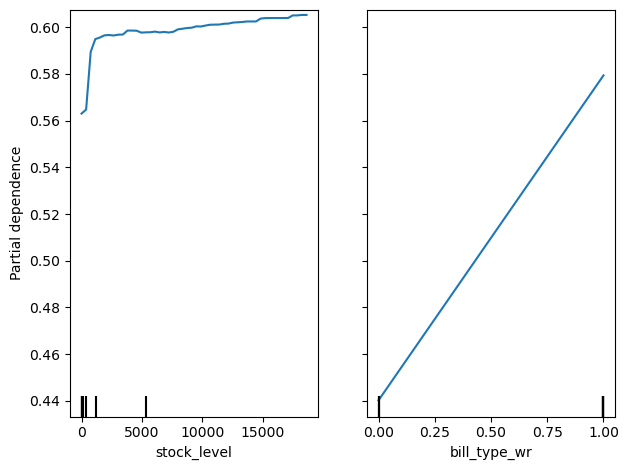

In [418]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# ویژگی‌هایی که می‌خوایم اثرشون بررسی بشه
features_to_plot = ['stock_level', 'bill_type_wr']

# رسم PDP
PartialDependenceDisplay.from_estimator(
    rf_clf,           # مدل جنگل تصادفی
    X_train,      # داده‌ها
    features_to_plot,
    kind='average',  # نوع PDP: average یعنی متوسط اثر
    grid_resolution=50  # تعداد نقاط برای رسم
)

plt.tight_layout()
plt.show()